<a href="https://colab.research.google.com/github/DrFrank25/Syndecan_4-Ag73/blob/main/RMSD_Complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Script Complex RMSD with Savitzky–Golay Smoothing**

In [ ]:
# --- Import libraries ---
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from scipy.signal import savgol_filter

In [ ]:
# ===== Settings =====
SMOOTH_WINDOW = 11  # maximum smoothing window size (must be odd)
POLY_ORDER = 2      # polynomial order for Savitzky–Golay
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
FIGSIZE = (11, 6)
DPI = 1200
# Legend names
LEGEND_NAMES = ["Run 1", "Run 2", "Run 3"]
# ====================

In [ ]:
# File upload
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Please upload .xvg files.")


Saving rmsd_synd@AG73_Run1.xvg to rmsd_synd@AG73_Run1.xvg
Saving rmsd_synd@AG73_Run2.xvg to rmsd_synd@AG73_Run2.xvg
Saving rmsd_synd@AG73_Run3.xvg to rmsd_synd@AG73_Run3.xvg


In [ ]:
# Function to read .xvg data
def read_xvg_from_bytes(content_bytes, encoding='utf-8'):
    s = content_bytes.decode(encoding, errors='replace')
    times, vals = [], []
    for line in s.splitlines():
        line = line.strip()
        if not line or line.startswith(('#', '@')):
            continue
        parts = line.split()
        if len(parts) >= 2:
            try:
                times.append(float(parts[0]))
                vals.append(float(parts[1]))
            except ValueError:
                continue
    return np.array(times), np.array(vals)

plt.figure(figsize=FIGSIZE)

<Figure size 1100x600 with 0 Axes>

<Figure size 1100x600 with 0 Axes>

In [ ]:
# Store interpolated runs for later statistics
all_interp = []

Run 1:
  Mean: 1.31 nm
  Standard deviation: 0.1 nm

Run 2:
  Mean: 1.61 nm
  Standard deviation: 0.3 nm

Run 3:
  Mean: 1.60 nm
  Standard deviation: 0.2 nm



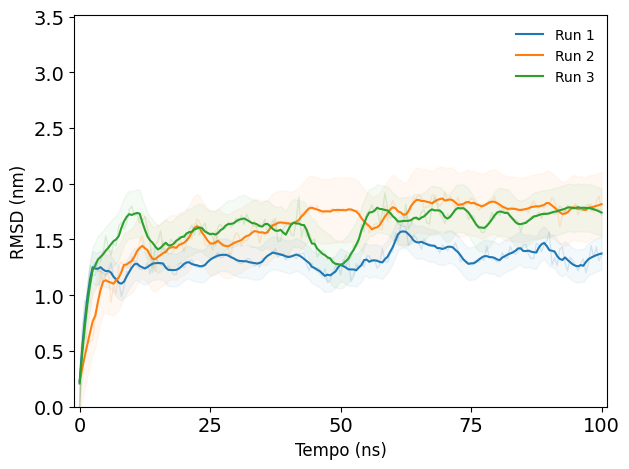

In [ ]:
# Loop over uploaded files
for i, (name, content) in enumerate(uploaded.items()):
    time, rmsd = read_xvg_from_bytes(content)

    if time.size == 0 or rmsd.size == 0:
        print(f"Warning: '{name}' contains no valid data. Skipping.")
        continue

    # Sort by time
    order = np.argsort(time)
    time = time[order]
    rmsd = rmsd[order]

    # --- Interpolation to normalize the time axis ---
    # Define a common time axis (e.g., 0 up to max, step of 0.5 ns)
    common_time = np.arange(0, np.nanmax(time), 0.5)  # adjust step here

    # Interpolate only valid points
    mask_valid_interp = np.isfinite(time) & np.isfinite(rmsd)
    rmsd_interp = np.interp(common_time, time[mask_valid_interp], rmsd[mask_valid_interp])

    # Replace variables for the rest of the code
    time = common_time
    rmsd = rmsd_interp
    all_interp.append(rmsd)

    # Mask for valid data
    mask_valid = np.isfinite(time) & np.isfinite(rmsd) & (time >= 0) & (rmsd >= 0)
    valid_points = np.sum(mask_valid)

    # Window adjustment for small datasets
    window = min(SMOOTH_WINDOW, valid_points if valid_points > 3 else 1)
    if window % 2 == 0:
        window = max(5, window - 1)  # window must be odd

    time_masked = np.where(mask_valid, time, np.nan)
    rmsd_masked = np.where(mask_valid, rmsd, np.nan)

    mean_val = np.nanmean(rmsd_masked)
    std_val = np.nanstd(rmsd_masked)

    # Savitzky–Golay smoothing
    if valid_points >= 3 and window > POLY_ORDER:
        smooth_valid = savgol_filter(
            rmsd_masked[mask_valid],
            window_length=window,
            polyorder=POLY_ORDER,
            mode='interp'
        )
        smooth = np.full_like(rmsd_masked, np.nan)
        smooth[mask_valid] = smooth_valid
    else:
        smooth = rmsd_masked.copy()

    color = COLORS[i % len(COLORS)]

    # Curve name for legend
    curve_name = LEGEND_NAMES[i] if i < len(LEGEND_NAMES) else f"Run {i+1}"

    # Raw curve
    valid_raw = np.isfinite(time_masked) & np.isfinite(rmsd_masked)
    plt.plot(time_masked[valid_raw], rmsd_masked[valid_raw],
             linewidth=1.0, alpha=0.15, color=color)

    # Smoothed curve
    valid_smooth = np.isfinite(time_masked) & np.isfinite(smooth)
    plt.plot(time_masked[valid_smooth], smooth[valid_smooth],
             label=f"{curve_name}")

    # ± standard deviation band
    low = smooth[valid_smooth] + std_val
    high = smooth[valid_smooth] - std_val
    plt.fill_between(time_masked[valid_smooth], low, high, alpha=0.05, color=color)

    print(f"{curve_name}:")
    print(f"  Mean: {mean_val:.2f} nm")
    print(f"  Standard deviation: {std_val:.1f} nm\n")

    # Axes configuration
    plt.xlabel("Time (ns)", fontsize=12)
    plt.ylabel("RMSD (nm)", fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Tick range
    plt.xlim(-1, 101)  # X-axis limits
    plt.ylim(0.1, 3.51)  # Y-axis limits
    plt.xticks(np.arange(0, 101, 25))     # from 0 to 100, step 25
    plt.yticks(np.arange(0.0, 3.51, 0.5))  # from 0 to 3.5, step 0.5

    # Desired run names
    run_names = ["Run 1", "Run 2", "Run 3"]


# Custom legend
plt.legend(
    loc='upper right',
    fontsize=10,
    frameon=True,
    facecolor='white',
    edgecolor='white',
    fancybox=False,
    shadow=False
)

plt.grid(False)
plt.tight_layout()

# --- save and render the figure (at the end of the script, BEFORE plt.show()) ---
fig = plt.gcf()  # get the current figure (the one just plotted)
fig.tight_layout()
fig.canvas.draw()  # force rendering in Colab
plt.show()

In [ ]:
# Save figure in high resolution with a specific name
fig.savefig(
    "rmsd_Complex.png",
    dpi=1200,
    bbox_inches='tight',
    transparent=False  # change to False if you prefer a solid background
)

from google.colab import files
files.download("rmsd_Complex.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ======================
# Overall mean of the 3 runs (raw values)
# ======================

# === Global statistics with raw data (from uploaded files) ===
all_values = []

for name, content in uploaded.items():
    time, rmsd = read_xvg_from_bytes(content)
    mask_valid = np.isfinite(rmsd) & (rmsd >= 0)
    if np.any(mask_valid):
        all_values.extend(rmsd[mask_valid])

all_values = np.array(all_values)

global_mean = np.mean(all_values)
global_std = np.std(all_values)

print("\n=== Global mean statistics (raw data) ===")
print(f"Global mean: {global_mean:.4f} nm")
print(f"Global standard deviation: {global_std:.4f} nm")


=== Global mean statistics (raw data) ===
Global mean: 1.5076 nm
Global standard deviation: 0.2491 nm


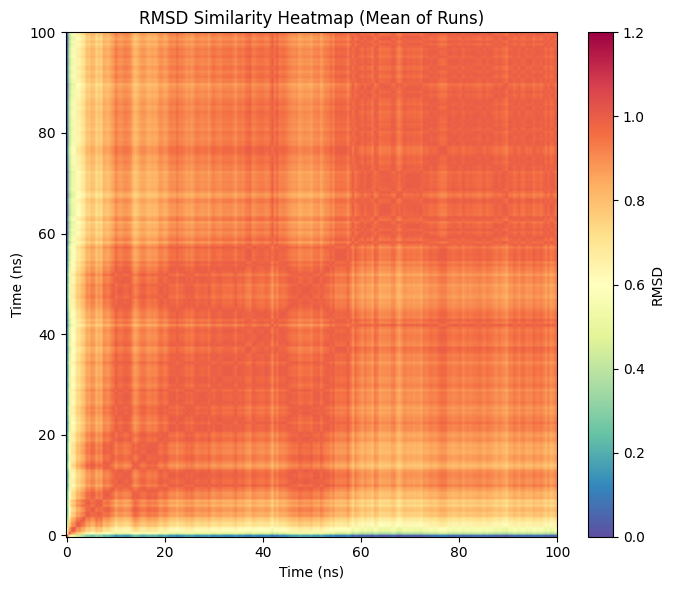

In [ ]:
# ======================
# Heatmap: RMSD similarity (time × time)
# ======================

if all_interp:
    # Align runs to the same length (padding with NaN)
    max_len = max(len(arr) for arr in all_interp)
    aligned = np.full((len(all_interp), max_len), np.nan)

    for i, arr in enumerate(all_interp):
        aligned[i, :len(arr)] = arr

    # Mean across runs
    rmsd_mean = np.nanmean(aligned, axis=0)

    # Time × time matrix
    n = len(rmsd_mean)
    rmsd_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            rmsd_matrix[i, j] = 1 - abs(rmsd_mean[i] - rmsd_mean[j]) / (
                np.nanmax(rmsd_mean) - np.nanmin(rmsd_mean)
            )

    # === Final Heatmap Plot ===
    plt.figure(figsize=(7, 6))
    im = plt.imshow(
        rmsd_matrix,
        origin="lower",
        cmap="Spectral_r",   # better alternative to jet
        aspect="auto",
        vmin=0, vmax=1.2
    )

    plt.colorbar(im, label="RMSD")
    plt.xlabel("Time (ns)")
    plt.ylabel("Time (ns)")
    plt.title("RMSD Similarity Heatmap (Mean of Runs)", fontsize=12)

    # Adjust ticks to show 0–100 ns instead of frames
    xticks = np.linspace(0, n, 6)
    plt.xticks(xticks, labels=[f"{int(x * (100/n))}" for x in xticks])
    plt.yticks(xticks, labels=[f"{int(x * (100/n))}" for x in xticks])

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No valid data available to construct the heatmap")

[Clustering] k=2 selected (silhouette=0.939)


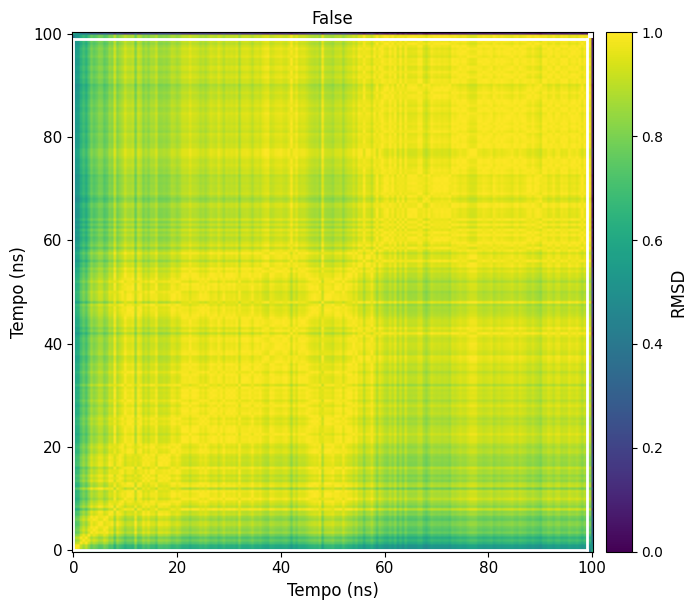

Representative frames (medoids) per cluster: {0: np.int64(78), 1: np.int64(0)}


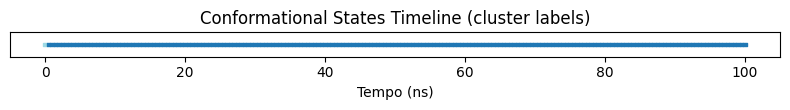

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Basic checks and conversions
assert rmsd_matrix.shape[0] == rmsd_matrix.shape[1], "Matrix must be square (time x time)."
S = np.clip(rmsd_matrix.astype(float), 0.0, 2.0)  # similarity 0–2
# distance (0 = identical, 2 = very different)
D = 2.0 - S
np.fill_diagonal(D, 0.0)

# 2) Automatic choice of k (clusters) using silhouette
best_k, best_score = None, -1.0
best_labels = None

try:
    from sklearn.cluster import SpectralClustering
    from sklearn.metrics import silhouette_score
except Exception as e:
    raise SystemExit("scikit-learn is required (pip install scikit-learn)") from e

# Test k from 2 to 8 (adjust if needed)
for k in range(2, min(8, S.shape[0]//5 + 2)):
    try:
        sc = SpectralClustering(
            n_clusters=k,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42
        )
        labels = sc.fit_predict(S)
        # silhouette requires features, so we use simple summaries of S as features
        X_feat = np.column_stack([S.mean(axis=1), S.var(axis=1)])
        score = silhouette_score(X_feat, labels)
        if score > best_score:
            best_k, best_score, best_labels = k, score, labels
    except Exception:
        continue

if best_labels is None:
    raise RuntimeError("Automatic k selection failed. Try adjusting the range of k.")

labels = best_labels
k = best_k
print(f"[Clustering] k={k} selected (silhouette={best_score:.3f})")

# 3) Reorder matrix by cluster and detect boundaries
order = np.argsort(labels)
S_ord = S[order][:, order]
labels_ord = labels[order]

bounds = []
start = 0
for c in range(k):
    size_c = np.sum(labels_ord == c)
    end = start + size_c
    bounds.append((start, end))
    start = end

# 4) Clustered heatmap with boundaries
plt.figure(figsize=(7.2, 6.2))
im = plt.imshow(S_ord, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("RMSD", fontsize=12)

# ticks in ns (0–100 ns). Map matrix indices → ns
n = S.shape[0]
xticks = np.linspace(0, n-1, 6, dtype=int)
tick_labels = [f"{int(x * (100/(n-1)))}" for x in xticks]
plt.xticks(xticks, tick_labels, fontsize=11)
plt.yticks(xticks, tick_labels, fontsize=11)
plt.xlabel("Tempo (ns)", fontsize=12)
plt.ylabel("Tempo (ns)", fontsize=12)
plt.title(False)

# draw cluster boundaries
for (a, b) in bounds:
    plt.plot([a, b-2], [a, a], color='white', lw=2)
    plt.plot([a, b-2], [b-2, b-2], color='white', lw=2)
    plt.plot([a, a], [a, b-2], color='white', lw=2)
    plt.plot([b-2, b-2], [a, b-2], color='white', lw=2)

plt.tight_layout()
plt.show()

# 5) Representative frames (medoids = min total distance in each cluster)
medoids = {}
for c in range(k):
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        continue
    subD = D[np.ix_(idx, idx)]
    center = idx[np.argmin(subD.sum(axis=1))]
    medoids[c] = center
print("Representative frames (medoids) per cluster:", medoids)

# 6) Cluster timeline (labels over real time)
plt.figure(figsize=(8, 1.0 + 0.1*k))
t = np.arange(n) * (100/(n-1))  # ns
plt.scatter(t, np.zeros_like(t), c=labels, cmap='tab20', s=8, marker='s')
plt.yticks([])
plt.xlabel("Tempo (ns)")
plt.title("Conformational States Timeline (cluster labels)")
plt.tight_layout()
plt.show()

[Clustering] k=2 selected (silhouette=0.939)


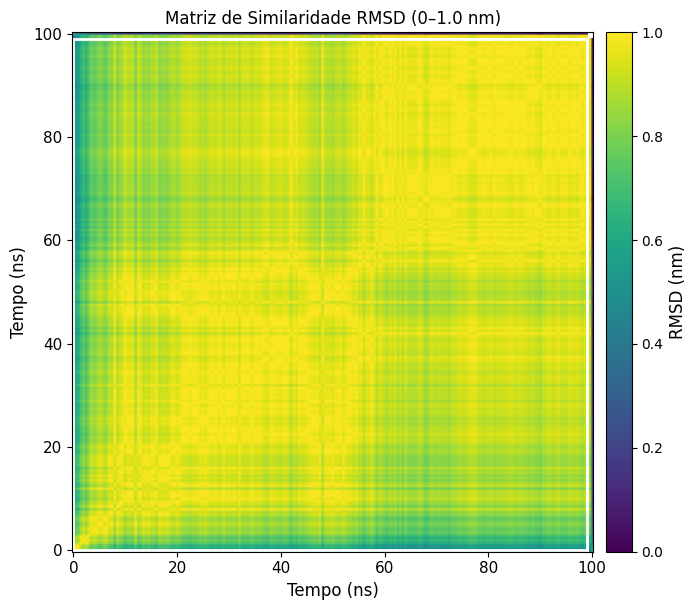

Representative frames (medoids) per cluster: {0: np.int64(78), 1: np.int64(0)}


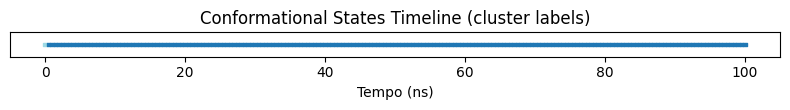

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Basic checks and conversions
assert rmsd_matrix.shape[0] == rmsd_matrix.shape[1], "Matrix must be square (time x time)."

# Clamp RMSD values in [0, 2]
S = np.clip(rmsd_matrix.astype(float), 0.0, 2.0)  # RMSD (nm)
# Distance matrix (0 = identical, 2 = very different)
D = 2.0 - S
np.fill_diagonal(D, 0.0)

# 2) Automatic choice of k (clusters) using silhouette
best_k, best_score = None, -1.0
best_labels = None

try:
    from sklearn.cluster import SpectralClustering
    from sklearn.metrics import silhouette_score
except Exception as e:
    raise SystemExit("scikit-learn is required (pip install scikit-learn)") from e

for k in range(2, min(8, S.shape[0]//5 + 2)):
    try:
        sc = SpectralClustering(
            n_clusters=k,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42
        )
        labels = sc.fit_predict(S)
        X_feat = np.column_stack([S.mean(axis=1), S.var(axis=1)])
        score = silhouette_score(X_feat, labels)
        if score > best_score:
            best_k, best_score, best_labels = k, score, labels
    except Exception:
        continue

if best_labels is None:
    raise RuntimeError("Automatic k selection failed. Try adjusting the range of k.")

labels = best_labels
k = best_k
print(f"[Clustering] k={k} selected (silhouette={best_score:.3f})")

# 3) Reorder matrix by cluster and detect boundaries
order = np.argsort(labels)
S_ord = S[order][:, order]
labels_ord = labels[order]

bounds = []
start = 0
for c in range(k):
    size_c = np.sum(labels_ord == c)
    end = start + size_c
    bounds.append((start, end))
    start = end

# 4) Clustered heatmap with RMSD scale 0–2
plt.figure(figsize=(7.2, 6.2))
im = plt.imshow(S_ord, origin='lower', cmap='viridis', vmin=0, vmax=1.0, aspect='auto')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("RMSD (nm)", fontsize=12)

# ticks in ns (0–100 ns). Map matrix indices → ns
n = S.shape[0]
xticks = np.linspace(0, n-1, 6, dtype=int)
tick_labels = [f"{int(x * (100/(n-1)))}" for x in xticks]
plt.xticks(xticks, tick_labels, fontsize=11)
plt.yticks(xticks, tick_labels, fontsize=11)
plt.xlabel("Tempo (ns)", fontsize=12)
plt.ylabel("Tempo (ns)", fontsize=12)
plt.title("Matriz de Similaridade RMSD (0–1.0 nm)")

# draw cluster boundaries
for (a, b) in bounds:
    plt.plot([a, b-2], [a, a], color='white', lw=2)
    plt.plot([a, b-2], [b-2, b-2], color='white', lw=2)
    plt.plot([a, a], [a, b-2], color='white', lw=2)
    plt.plot([b-2, b-2], [a, b-2], color='white', lw=2)

plt.tight_layout()
plt.show()

# 5) Representative frames (medoids)
medoids = {}
for c in range(k):
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        continue
    subD = D[np.ix_(idx, idx)]
    center = idx[np.argmin(subD.sum(axis=1))]
    medoids[c] = center
print("Representative frames (medoids) per cluster:", medoids)

# 6) Cluster timeline (labels over real time)
plt.figure(figsize=(8, 1.0 + 0.1*k))
t = np.arange(n) * (100/(n-1))  # ns
plt.scatter(t, np.zeros_like(t), c=labels, cmap='tab20', s=8, marker='s')
plt.yticks([])
plt.xlabel("Tempo (ns)")
plt.title("Conformational States Timeline (cluster labels)")
plt.tight_layout()
plt.show()

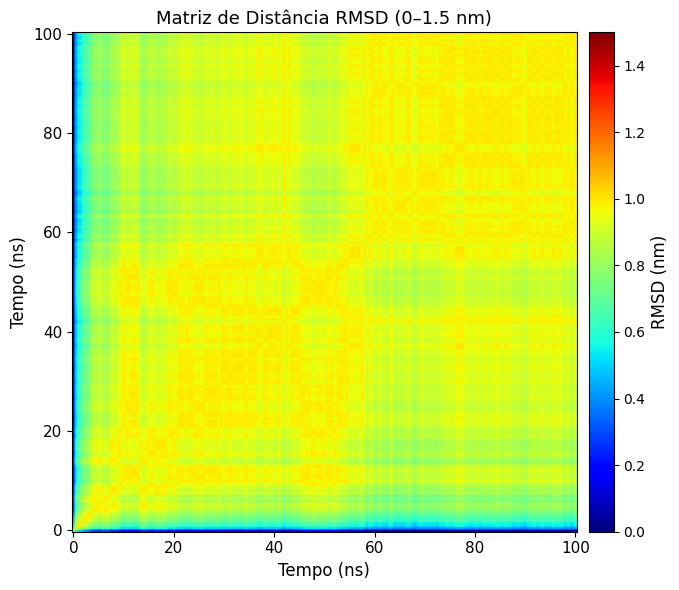

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- matriz de distâncias (0–1.5 nm) ---
D = rmsd_matrix.astype(float)
D[D > 1.5] = 1.5


# --- plot estilo artigo ---
plt.figure(figsize=(7, 6))
im = plt.imshow(D, origin='lower', cmap='jet', vmin=0.0, vmax=1.5, aspect='auto')

# colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("RMSD (nm)", fontsize=12)

# ticks em ns (0–100)
n = D.shape[0]
xticks = np.linspace(0, n-1, 6, dtype=int)
tick_labels = [f"{int(x * (100/(n-1)))}" for x in xticks]
plt.xticks(xticks, tick_labels, fontsize=11)
plt.yticks(xticks, tick_labels, fontsize=11)

plt.xlabel("Tempo (ns)", fontsize=12)
plt.ylabel("Tempo (ns)", fontsize=12)
plt.title("Matriz de Distância RMSD (0–1.5 nm)", fontsize=13)

plt.tight_layout()
plt.show()


In [ ]:
# --- salvar figura ---
fig_hmap = plt.gcf()  # pega a figura atual
fig_hmap.savefig("rmsd_heatmap_complex.png", dpi=1200, bbox_inches="tight")

# --- baixar no Colab ---
from google.colab import files
files.download("rmsd_heatmap_complex.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>